In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x

In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type='none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'layer'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:20<00:00, 12.88it/s]


Epoch:  0 Train Loss:  0.09019692414119031 Train Accuracy:  13.906924567426998 Train F1 Macro:  0.12136061971000416 Train F1 Micro:  0.13906924567426998
Epoch:  0 Validation Loss:  0.0798087247299635 Validation Accuracy:  21.989777724949484 Validation F1 Macro:  0.18734557164647295 Validation F1 Micro:  0.21989777724949483
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  1 Train Loss:  0.07436008354814906 Train Accuracy:  26.433694802325185 Train F1 Macro:  0.24417090874413414 Train F1 Micro:  0.26433694802325186
Epoch:  1 Validation Loss:  0.0678264190095593 Validation Accuracy:  31.570188993224775 Validation F1 Macro:  0.2879003047193637 Validation F1 Micro:  0.31570188993224774
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  2 Train Loss:  0.0668529129232561 Train Accuracy:  32.549206241289056 Train F1 Macro:  0.3113384293188913 Train F1 Micro:  0.3254920624128905
Epoch:  2 Validation Loss:  0.06417167908680874 Validation Accuracy:  35.54023535005349 Validation F1 Macro:  0.33293698325528176 Validation F1 Micro:  0.3554023535005349
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  3 Train Loss:  0.06279698565688922 Train Accuracy:  35.850018696671995 Train F1 Macro:  0.34870873132197794 Train F1 Micro:  0.3585001869667199
Epoch:  3 Validation Loss:  0.06118267667955271 Validation Accuracy:  37.1330084393201 Validation F1 Macro:  0.3561237826775974 Validation F1 Micro:  0.371330084393201
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.83it/s]


Epoch:  4 Train Loss:  0.05983291311121718 Train Accuracy:  38.77689771220722 Train F1 Macro:  0.37923390845910715 Train F1 Micro:  0.38776897712207226
Epoch:  4 Validation Loss:  0.058000875421955034 Validation Accuracy:  41.40021395459408 Validation F1 Macro:  0.40372272841353335 Validation F1 Micro:  0.4140021395459408
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.89it/s]


Epoch:  5 Train Loss:  0.0573398957348301 Train Accuracy:  41.1428765679709 Train F1 Macro:  0.40499416171372815 Train F1 Micro:  0.411428765679709
Epoch:  5 Validation Loss:  0.05565632251487056 Validation Accuracy:  42.98110067752288 Validation F1 Macro:  0.41064831550952063 Validation F1 Micro:  0.4298110067752288
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.85it/s]


Epoch:  6 Train Loss:  0.055394459573936544 Train Accuracy:  43.11112621953293 Train F1 Macro:  0.4258910638685835 Train F1 Micro:  0.43111126219532925
Epoch:  6 Validation Loss:  0.05322596541656037 Validation Accuracy:  45.34648757874717 Validation F1 Macro:  0.44260674451139226 Validation F1 Micro:  0.45346487578747174
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  7 Train Loss:  0.05359786805822252 Train Accuracy:  45.20175408777238 Train F1 Macro:  0.4472266889618932 Train F1 Micro:  0.4520175408777238
Epoch:  7 Validation Loss:  0.05283804714474258 Validation Accuracy:  45.69119220254368 Validation F1 Macro:  0.4343314376410182 Validation F1 Micro:  0.45691192202543685
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


Epoch:  8 Train Loss:  0.051848279468206866 Train Accuracy:  46.83346364347146 Train F1 Macro:  0.46410365832524647 Train F1 Micro:  0.4683346364347146
Epoch:  8 Validation Loss:  0.05090268679971886 Validation Accuracy:  49.01937477713063 Validation F1 Macro:  0.4881196630444442 Validation F1 Micro:  0.4901937477713063
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


Epoch:  9 Train Loss:  0.05039495097005149 Train Accuracy:  48.32239861304688 Train F1 Macro:  0.4785279820735439 Train F1 Micro:  0.4832239861304688
Epoch:  9 Validation Loss:  0.04852765340003335 Validation Accuracy:  49.19767027219779 Validation F1 Macro:  0.4770057360315461 Validation F1 Micro:  0.4919767027219779
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.89it/s]


Epoch:  10 Train Loss:  0.0489269634696415 Train Accuracy:  49.9711051432845 Train F1 Macro:  0.4956974645985093 Train F1 Micro:  0.49971105143284494
Epoch:  10 Validation Loss:  0.047264068571322176 Validation Accuracy:  51.53928444074647 Validation F1 Macro:  0.5093106084798297 Validation F1 Micro:  0.5153928444074647
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.83it/s]


Epoch:  11 Train Loss:  0.047344410604253304 Train Accuracy:  51.49403406193698 Train F1 Macro:  0.5110065367551749 Train F1 Micro:  0.5149403406193698
Epoch:  11 Validation Loss:  0.0480508419934031 Validation Accuracy:  50.10103411387139 Validation F1 Macro:  0.4875665236112062 Validation F1 Micro:  0.5010103411387139
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.84it/s]


Epoch:  12 Train Loss:  0.04610017011421487 Train Accuracy:  53.05775571948194 Train F1 Macro:  0.5272956965114486 Train F1 Micro:  0.5305775571948194
Epoch:  12 Validation Loss:  0.044488617108662545 Validation Accuracy:  54.99821704504932 Validation F1 Macro:  0.5472065209205106 Validation F1 Micro:  0.5499821704504932
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  13 Train Loss:  0.044982397901163707 Train Accuracy:  53.80562259917735 Train F1 Macro:  0.5347543523904846 Train F1 Micro:  0.5380562259917735
Epoch:  13 Validation Loss:  0.04404209020530853 Validation Accuracy:  54.59408058956377 Validation F1 Macro:  0.5376808006076423 Validation F1 Micro:  0.5459408058956376
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.85it/s]


Epoch:  14 Train Loss:  0.043817205612974815 Train Accuracy:  55.48492368358432 Train F1 Macro:  0.5522260848161544 Train F1 Micro:  0.5548492368358432
Epoch:  14 Validation Loss:  0.043073273496453235 Validation Accuracy:  56.48401283727564 Validation F1 Macro:  0.5651907693588887 Validation F1 Micro:  0.5648401283727564
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.90it/s]


Epoch:  15 Train Loss:  0.04263599229044547 Train Accuracy:  56.31097664615699 Train F1 Macro:  0.5608513304659373 Train F1 Micro:  0.5631097664615698
Epoch:  15 Validation Loss:  0.04112690237647328 Validation Accuracy:  58.56412694639249 Validation F1 Macro:  0.58447292855455 Validation F1 Micro:  0.5856412694639249
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.87it/s]


Epoch:  16 Train Loss:  0.041654937178231835 Train Accuracy:  57.63674066016249 Train F1 Macro:  0.5744505991147103 Train F1 Micro:  0.5763674066016249
Epoch:  16 Validation Loss:  0.03962060789829285 Validation Accuracy:  60.00237727326756 Validation F1 Macro:  0.5985995764930377 Validation F1 Micro:  0.6000237727326756
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.71it/s]


Epoch:  17 Train Loss:  0.04078079789201201 Train Accuracy:  58.53418091579699 Train F1 Macro:  0.5838988693773949 Train F1 Micro:  0.5853418091579699
Epoch:  17 Validation Loss:  0.040373071165582475 Validation Accuracy:  59.52692261975514 Validation F1 Macro:  0.5933684124005846 Validation F1 Micro:  0.5952692261975514
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  18 Train Loss:  0.039901725632023405 Train Accuracy:  59.35003569364653 Train F1 Macro:  0.5920747362289981 Train F1 Micro:  0.5935003569364653
Epoch:  18 Validation Loss:  0.04060329466484311 Validation Accuracy:  58.61167241174373 Validation F1 Macro:  0.5890090903183727 Validation F1 Micro:  0.5861167241174373
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.67it/s]


Epoch:  19 Train Loss:  0.038965811994295656 Train Accuracy:  60.21688139511166 Train F1 Macro:  0.6007208072229243 Train F1 Micro:  0.6021688139511167
Epoch:  19 Validation Loss:  0.03847572252616635 Validation Accuracy:  61.08403661000832 Validation F1 Macro:  0.6056554288943078 Validation F1 Micro:  0.6108403661000832
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.90it/s]


Epoch:  20 Train Loss:  0.03819634082076883 Train Accuracy:  61.1789101539926 Train F1 Macro:  0.6106665523732835 Train F1 Micro:  0.6117891015399259
Epoch:  20 Validation Loss:  0.036898902320385715 Validation Accuracy:  62.843218828004275 Validation F1 Macro:  0.630405321586599 Validation F1 Micro:  0.6284321882800428
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  21 Train Loss:  0.03745723473376127 Train Accuracy:  61.68881939014855 Train F1 Macro:  0.6163254987818982 Train F1 Micro:  0.6168881939014855
Epoch:  21 Validation Loss:  0.037202556259663566 Validation Accuracy:  62.201355045762504 Validation F1 Macro:  0.6181838760762329 Validation F1 Micro:  0.6220135504576251
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.85it/s]


Epoch:  22 Train Loss:  0.036673370960369295 Train Accuracy:  62.885406397661214 Train F1 Macro:  0.6282995564222214 Train F1 Micro:  0.6288540639766121
Epoch:  22 Validation Loss:  0.036359876590875785 Validation Accuracy:  63.3186734815167 Validation F1 Macro:  0.6363784346676049 Validation F1 Micro:  0.633186734815167
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  23 Train Loss:  0.0362354656871691 Train Accuracy:  63.25594044260122 Train F1 Macro:  0.6320998630831945 Train F1 Micro:  0.6325594044260122
Epoch:  23 Validation Loss:  0.034132100150217615 Validation Accuracy:  65.55331035302508 Validation F1 Macro:  0.6533904148014683 Validation F1 Micro:  0.6555331035302508
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.91it/s]


Epoch:  24 Train Loss:  0.03564620450193246 Train Accuracy:  64.15678009314341 Train F1 Macro:  0.6410785070257431 Train F1 Micro:  0.6415678009314342
Epoch:  24 Validation Loss:  0.034618804493203224 Validation Accuracy:  64.98276476881017 Validation F1 Macro:  0.6500388182333322 Validation F1 Micro:  0.6498276476881018
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.84it/s]


Epoch:  25 Train Loss:  0.03487290240737856 Train Accuracy:  64.71428085800727 Train F1 Macro:  0.6468204696995081 Train F1 Micro:  0.6471428085800728
Epoch:  25 Validation Loss:  0.03422984487588434 Validation Accuracy:  65.54142398668728 Validation F1 Macro:  0.6568966959777833 Validation F1 Micro:  0.6554142398668727
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  26 Train Loss:  0.03428709677594335 Train Accuracy:  65.26498283305571 Train F1 Macro:  0.6524181815712297 Train F1 Micro:  0.6526498283305572
Epoch:  26 Validation Loss:  0.03428416004061033 Validation Accuracy:  65.49387852133603 Validation F1 Macro:  0.6567644209101614 Validation F1 Micro:  0.6549387852133602
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.87it/s]


Epoch:  27 Train Loss:  0.033824477097428654 Train Accuracy:  65.60832171873406 Train F1 Macro:  0.6559577812798112 Train F1 Micro:  0.6560832171873406
Epoch:  27 Validation Loss:  0.03278365361234258 Validation Accuracy:  66.74194698680613 Validation F1 Macro:  0.6651099632316757 Validation F1 Micro:  0.6674194698680613
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  28 Train Loss:  0.03316753248259525 Train Accuracy:  66.30859706972159 Train F1 Macro:  0.6631351516814002 Train F1 Micro:  0.6630859706972159
Epoch:  28 Validation Loss:  0.03292795523698245 Validation Accuracy:  66.813265184833 Validation F1 Macro:  0.6700721370041732 Validation F1 Micro:  0.6681326518483299
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  29 Train Loss:  0.03257039466218539 Train Accuracy:  66.82190570078525 Train F1 Macro:  0.6684837940291563 Train F1 Micro:  0.6682190570078526
Epoch:  29 Validation Loss:  0.03222624366509848 Validation Accuracy:  66.8251515511708 Validation F1 Macro:  0.6650571917628527 Validation F1 Micro:  0.668251515511708
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  30 Train Loss:  0.032161280186085446 Train Accuracy:  67.28422340823333 Train F1 Macro:  0.6729363033784427 Train F1 Micro:  0.6728422340823333
Epoch:  30 Validation Loss:  0.03132753539199454 Validation Accuracy:  68.1683109473434 Validation F1 Macro:  0.682329223767307 Validation F1 Micro:  0.681683109473434
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.70it/s]


Epoch:  31 Train Loss:  0.031673332924310675 Train Accuracy:  67.74654111568141 Train F1 Macro:  0.677781084969502 Train F1 Micro:  0.6774654111568141
Epoch:  31 Validation Loss:  0.030869628331202978 Validation Accuracy:  69.11922025436824 Validation F1 Macro:  0.6942287971985999 Validation F1 Micro:  0.6911922025436824
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  32 Train Loss:  0.03120444085635517 Train Accuracy:  68.46041404629976 Train F1 Macro:  0.6848981343544024 Train F1 Micro:  0.6846041404629976
Epoch:  32 Validation Loss:  0.031073682221832988 Validation Accuracy:  68.66753833353144 Validation F1 Macro:  0.6878944187660265 Validation F1 Micro:  0.6866753833353144
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.83it/s]


Epoch:  33 Train Loss:  0.030781475135721395 Train Accuracy:  68.83774688105517 Train F1 Macro:  0.6884994497072422 Train F1 Micro:  0.6883774688105517
Epoch:  33 Validation Loss:  0.029906584941135014 Validation Accuracy:  69.98692499702841 Validation F1 Macro:  0.6992561785442666 Validation F1 Micro:  0.6998692499702841
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  34 Train Loss:  0.030340126569239397 Train Accuracy:  69.3816500662882 Train F1 Macro:  0.6941359579426143 Train F1 Micro:  0.693816500662882
Epoch:  34 Validation Loss:  0.030330612414177654 Validation Accuracy:  69.27374301675978 Validation F1 Macro:  0.6943031368371203 Validation F1 Micro:  0.6927374301675978
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  35 Train Loss:  0.030078463483546466 Train Accuracy:  69.57881497093517 Train F1 Macro:  0.6960553984101336 Train F1 Micro:  0.6957881497093518
Epoch:  35 Validation Loss:  0.029157036486568085 Validation Accuracy:  70.7595388089861 Validation F1 Macro:  0.7097294293297193 Validation F1 Micro:  0.7075953880898609
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.84it/s]


Epoch:  36 Train Loss:  0.029499630473036696 Train Accuracy:  70.44566067240031 Train F1 Macro:  0.7047260262835162 Train F1 Micro:  0.7044566067240031
Epoch:  36 Validation Loss:  0.02895357694025628 Validation Accuracy:  71.24687982883633 Validation F1 Macro:  0.7132901257273302 Validation F1 Micro:  0.7124687982883633
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.82it/s]


Epoch:  37 Train Loss:  0.029291117408523044 Train Accuracy:  70.61223102287792 Train F1 Macro:  0.7066000159112704 Train F1 Micro:  0.7061223102287792
Epoch:  37 Validation Loss:  0.028850876865581937 Validation Accuracy:  71.04481160109356 Validation F1 Macro:  0.7103874851695283 Validation F1 Micro:  0.7104481160109355
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.78it/s]


Epoch:  38 Train Loss:  0.02888086180750654 Train Accuracy:  70.98956385763334 Train F1 Macro:  0.710180075587218 Train F1 Micro:  0.7098956385763334
Epoch:  38 Validation Loss:  0.02860876989041556 Validation Accuracy:  71.23499346249852 Validation F1 Macro:  0.7131268483959883 Validation F1 Micro:  0.7123499346249852
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  39 Train Loss:  0.028602535830731583 Train Accuracy:  71.3906924567427 Train F1 Macro:  0.7142421130498949 Train F1 Micro:  0.713906924567427
Epoch:  39 Validation Loss:  0.028419821829216582 Validation Accuracy:  71.40140259122786 Validation F1 Macro:  0.7146102119575117 Validation F1 Micro:  0.7140140259122786
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.74it/s]


Epoch:  40 Train Loss:  0.028297912964268278 Train Accuracy:  71.78842166094435 Train F1 Macro:  0.7182496214640013 Train F1 Micro:  0.7178842166094436
Epoch:  40 Validation Loss:  0.02805992480490078 Validation Accuracy:  72.25722096755021 Validation F1 Macro:  0.7243350728496263 Validation F1 Micro:  0.7225722096755022
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.77it/s]


Epoch:  41 Train Loss:  0.028091227246014854 Train Accuracy:  71.88020532345243 Train F1 Macro:  0.7191210600485034 Train F1 Micro:  0.7188020532345243
Epoch:  41 Validation Loss:  0.02741246871782174 Validation Accuracy:  72.5781528586711 Validation F1 Macro:  0.726199405378395 Validation F1 Micro:  0.7257815285867111
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.55it/s]


Epoch:  42 Train Loss:  0.027833283061007328 Train Accuracy:  72.17255328551518 Train F1 Macro:  0.7221205656033531 Train F1 Micro:  0.7217255328551517
Epoch:  42 Validation Loss:  0.027541173618691125 Validation Accuracy:  72.75644835373825 Validation F1 Macro:  0.7283473981829974 Validation F1 Micro:  0.7275644835373825
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.67it/s]


Epoch:  43 Train Loss:  0.02760577782652706 Train Accuracy:  72.43090729850087 Train F1 Macro:  0.7247758109867941 Train F1 Micro:  0.7243090729850087
Epoch:  43 Validation Loss:  0.027488144450921386 Validation Accuracy:  73.04172114584571 Validation F1 Macro:  0.7308554007686984 Validation F1 Micro:  0.7304172114584572
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  44 Train Loss:  0.02739366557716687 Train Accuracy:  72.61447462351701 Train F1 Macro:  0.7268097838576457 Train F1 Micro:  0.7261447462351701
Epoch:  44 Validation Loss:  0.02692899854850871 Validation Accuracy:  73.16058480922382 Validation F1 Macro:  0.7306354255349689 Validation F1 Micro:  0.7316058480922382
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.79it/s]


Epoch:  45 Train Loss:  0.027243895139158324 Train Accuracy:  72.74025223510215 Train F1 Macro:  0.7277757740024774 Train F1 Micro:  0.7274025223510217
Epoch:  45 Validation Loss:  0.02691875063400978 Validation Accuracy:  73.29133483893973 Validation F1 Macro:  0.7343611159788616 Validation F1 Micro:  0.7329133483893974
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.80it/s]


Epoch:  46 Train Loss:  0.027041795726506005 Train Accuracy:  73.15497841384233 Train F1 Macro:  0.7320160147648216 Train F1 Micro:  0.7315497841384232
Epoch:  46 Validation Loss:  0.026716703741867562 Validation Accuracy:  73.68358492808748 Validation F1 Macro:  0.7376220595735897 Validation F1 Micro:  0.7368358492808749
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.76it/s]


Epoch:  47 Train Loss:  0.026937023799570234 Train Accuracy:  73.31135057959683 Train F1 Macro:  0.7334042078692469 Train F1 Micro:  0.7331135057959685
Epoch:  47 Validation Loss:  0.02701571632013244 Validation Accuracy:  72.85153928444075 Validation F1 Macro:  0.7277170885943263 Validation F1 Micro:  0.7285153928444075
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.85it/s]


Epoch:  48 Train Loss:  0.026888000622488452 Train Accuracy:  73.2943536050583 Train F1 Macro:  0.7332402893437114 Train F1 Micro:  0.732943536050583
Epoch:  48 Validation Loss:  0.02646849301692267 Validation Accuracy:  73.71924402710091 Validation F1 Macro:  0.7380453668719344 Validation F1 Micro:  0.7371924402710092
---------------------------------------------------------------


100%|██████████| 263/263 [00:20<00:00, 12.75it/s]


Epoch:  49 Train Loss:  0.026678044587413244 Train Accuracy:  73.63769249073665 Train F1 Macro:  0.7368348885815952 Train F1 Micro:  0.7363769249073665
Epoch:  49 Validation Loss:  0.026679563569098723 Validation Accuracy:  73.71924402710091 Validation F1 Macro:  0.7376571070899827 Validation F1 Micro:  0.7371924402710092
---------------------------------------------------------------


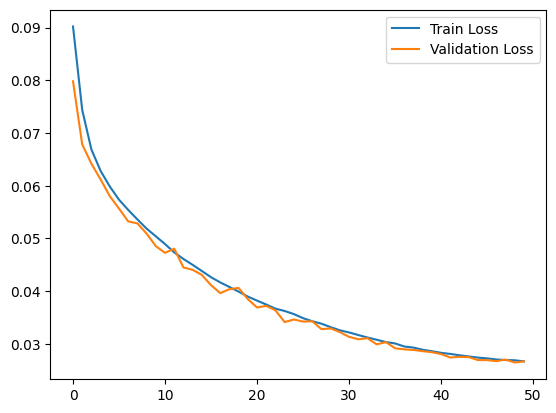

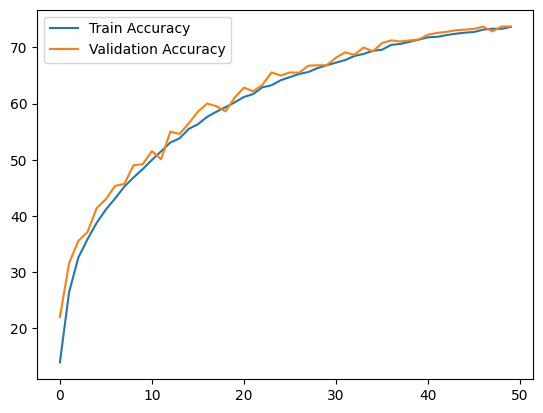

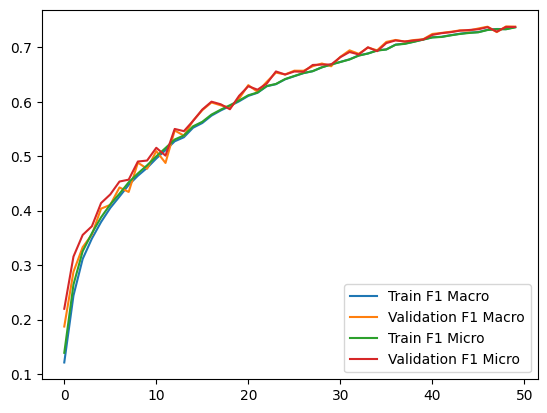

In [5]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-custom_layernorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-custom_layernorm.pth')
    
    
training()